In [20]:
import numpy as np
#cleanup tasks - venkata
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats.mstats import winsorize

scaler = StandardScaler()

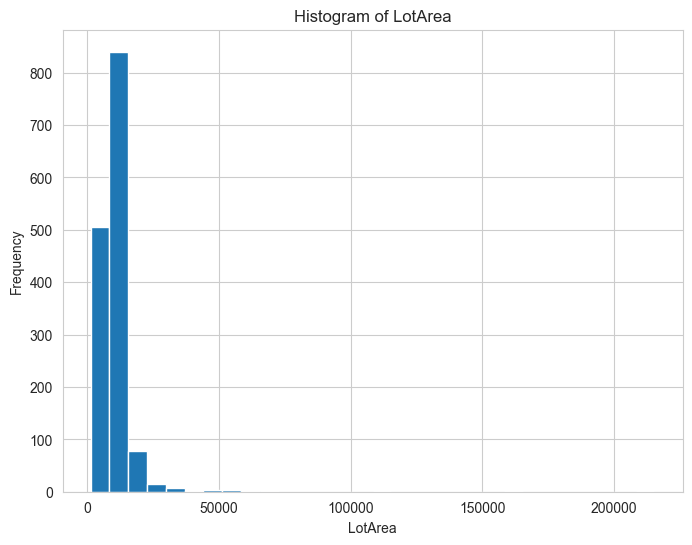

In [24]:
test_df = pd.read_csv('../docs/test.csv')
# test_df.head()
train_df = pd.read_csv('../docs/train.csv')

# Visualize outliers for a specific column (e.g., 'LotArea')
train_df['LotArea'].hist(bins=30, figsize=(8, 6))
plt.title('Histogram of LotArea')
plt.xlabel('LotArea')
plt.ylabel('Frequency')
plt.show()

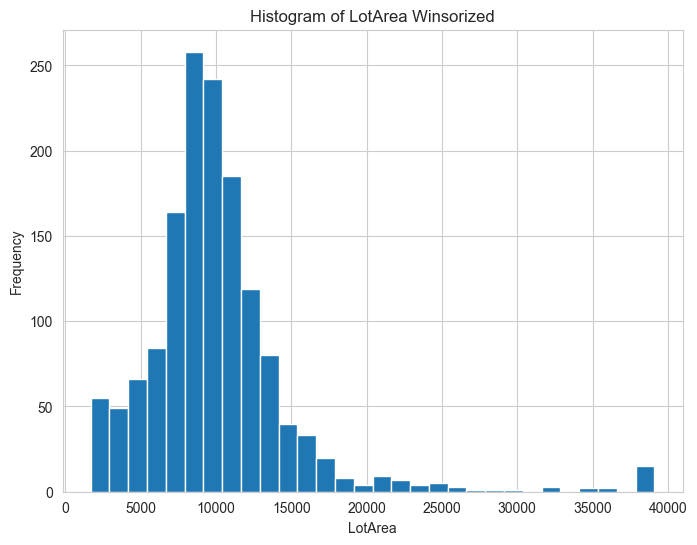

In [26]:
#remove outliers
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.01)
        Q3 = df[col].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

def winsorize_data(df, columns, limits=(0.01, 0.01)):
   for col in columns:
       df[col] = winsorize(df[col], limits=limits)
   return df

numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols_winsor_list = [col for col in numerical_cols if col != 'Id']
# Remove outliers from the training dataset
train_df_cleaned = winsorize_data(train_df, numerical_cols_winsor_list)

train_df_cleaned['LotArea'].hist(bins=30, figsize=(8, 6))
plt.title('Histogram of LotArea Winsorized')
plt.xlabel('LotArea')
plt.ylabel('Frequency')
plt.show()

In [16]:

# missing_values_in_test = test_df.isnull().sum()
# print(missing_values_in_test)

def remove_highly_correlated_features(train_df, test_df, threshold=0.85):
    # Compute the correlation matrix
    corr_matrix = train_df.corr(numeric_only=True)

    to_drop = [column for column in corr_matrix.columns if any(corr_matrix[column] > threshold)]

    # Drop the highly correlated columns
    train_df = train_df.drop(columns=to_drop)
    test_df = test_df.drop(columns=to_drop)
    return train_df, test_df


def process_correlation(train_df, test_df):
    # Compute the correlation matrix
    correlation_matrix = train_df.corr(numeric_only=True)

    # Visualize the correlation matrix
    # plt.figure(figsize=(10, 8))
    # sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    # plt.title('Correlation Matrix')
    # plt.show()
    remove_highly_correlated_features(train_df, test_df)

def preprocess_data(train_df, test_df):

    # Identify numerical and categorical columns
    numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns

    # Scale numerical columns
    scaler = StandardScaler()
    train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
    test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])
    # Encode categorical columns
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_categorical = encoder.fit_transform(train_df[categorical_cols])
    encoded_categorical_test = encoder.transform(test_df[categorical_cols])
    # Convert encoded values to a DataFrame
    encoded_categorical_df = pd.DataFrame(
        encoded_categorical,
        columns=encoder.get_feature_names_out(categorical_cols),
        index=train_df.index
    )
    encoded_categorical_df_test = pd.DataFrame(encoded_categorical_test,
        columns=encoder.get_feature_names_out(categorical_cols),
        index=test_df.index
    )
    # Drop original categorical columns and concatenate the encoded DataFrame
    train_df = pd.concat([train_df.drop(categorical_cols, axis=1), encoded_categorical_df], axis=1)
    test_df = pd.concat([test_df.drop(categorical_cols, axis=1), encoded_categorical_df_test], axis=1)

    # Align the train and test DataFrames
    train_df = train_df.drop(columns=['Id'])  # Drop ID column
    test_ids = test_df['Id']
    test_df = test_df.drop(columns=['Id'])

    # process correlation features
    process_correlation(train_df, test_df)

    return train_df, test_df

In [17]:
def get_training_data():
    global y_train, y_test, X_train_ready, X_test_ready
    # Load the dataset
    X = train_df.drop('SalePrice', axis=1)  # Replace 'target_column' with the actual target column name
    y = train_df['SalePrice']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # preprocess
    X_train_ready, X_test_ready = preprocess_data(X_train, X_test)
    print(X_train_ready.info())
    return X_train_ready, X_test_ready, y_train, y_test


In [18]:
X_train, X_test, y_train, y_test = get_training_data()

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_ready, y_train)

# Predict on the test data
predictions_rf = model.predict(X_test_ready)
X_test_ready['SalePriceRF'] = predictions_rf

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions_rf)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

# Print the result
print(f"Root Mean Squared Error of Random Forest: {rmse}")
print(X_test_ready.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 254 to 1126
Columns: 301 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(301)
memory usage: 2.7 MB
None
Root Mean Squared Error of Random Forest: 23729.75207450082
      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
892    -0.866764    -0.013818 -0.338319    -0.092926     2.190010  -0.268307   
1105    0.074110     1.111406  0.402357     1.383770    -0.536027   0.756360   
413    -0.631546    -0.576430 -0.233059    -0.831274     0.372652  -1.458244   
522    -0.161109    -0.817550 -0.996484    -0.092926     1.281331  -0.797168   
1036   -0.866764     0.749727  0.526125     2.122118    -0.536027   1.186060   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_New  \
892       0.873807   -0.591489    0.520430     -0.2938  ...           0.0   
1105      0.487725    1.386985    1.383270     -0.2938  ...           0.0   
413      -1.683983   -0.591489   -1.029875     -0.29